<a href="https://colab.research.google.com/github/Lukog05/Deep-Learning-Project/blob/main/Model1_emotion_detection_fer_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1

# Training the dataset for Real faces

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter

# Paths for training and testing datasets
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Normalization for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define data generators for training and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False  # Disabling shuffling for testing
)

# Compute class weights
train_class_counts = Counter(train_generator.classes)
max_count = max(train_class_counts.values())
class_weights = {i: max_count / count for i, count in train_class_counts.items()}

# Print the class weights for review
print("Class Weights:", class_weights)

# Loading the VGG16 model with pretrained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Building the model
model = Sequential([
    Conv2D(3, (3, 3), padding="same", input_shape=(48, 48, 1)),  # Convert grayscale to RGB
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# We Freeze the base model initially and compile it
base_model.trainable = False
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Training our model with the frozen base model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze the base model for fine-tuning (last few layers only)
for layer in base_model.layers[:-4]:  # Keeping only the last 4 layers as trainable
    layer.trainable = False
base_model.trainable = True

# Compile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('emotion_detection_vgg16_finetuned.h5')

# Evaluating the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights: {0: 1.8060075093867334, 1: 16.548165137614678, 2: 1.7610446668293873, 3: 1.0, 4: 1.4531722054380665, 5: 1.4937888198757765, 6: 2.275307473982971}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733746560.781553     131 service.cc:145] XLA service 0x79a0b800f4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733746560.781626     131 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733746560.781632     131 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/449 ━━━━━━━━━━━━━━━━━━━━ 1:40:26 13s/step - accuracy: 0.0625 - loss: 4.1461

I0000 00:00:1733746569.876177     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 215s 450ms/step - accuracy: 0.1938 - loss: 3.4866 - val_accuracy: 0.2451 - val_loss: 1.8517 - learning_rate: 0.0010
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.2449 - loss: 3.2077 - val_accuracy: 0.3412 - val_loss: 1.6889 - learning_rate: 0.0010
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.2713 - loss: 3.1104 - val_accuracy: 0.3172 - val_loss: 1.7075 - learning_rate: 0.0010
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.2712 - loss: 3.1540 - val_accuracy: 0.3402 - val_loss: 1.6756 - learning_rate: 0.0010
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.2797 - loss: 3.1530 - val_accuracy: 0.3267 - val_loss: 1.6844 - learning_rate: 0.0010
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 66s 144ms/step - accuracy: 0.2862 - loss: 3.1003 - val_accuracy: 0.3274 - val_loss: 1.6904 - learning_rate: 0.0010
Epoch 7/20
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2906 - loss:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,942,897 (171.44 MB)

 Trainable params: 14,980,965 (57.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,961,932 (114.30 MB)

#Final Training results
### Here we extract and print the final training and validation accuracies

In [ ]:
# Final training accuracy and validation accuracy for the initial phase
final_train_acc_initial = history.history['accuracy'][-1]
final_val_acc_initial = history.history['val_accuracy'][-1]

# Final training accuracy and validation accuracy for the fine-tuning phase
final_train_acc_fine = history_fine.history['accuracy'][-1]
final_val_acc_fine = history_fine.history['val_accuracy'][-1]

print("Initial Training Phase:")
print(f"  Final Training Accuracy: {final_train_acc_initial:.4f}")
print(f"  Final Validation Accuracy: {final_val_acc_initial:.4f}")

print("\nFine-Tuning Phase:")
print(f"  Final Training Accuracy: {final_train_acc_fine:.4f}")
print(f"  Final Validation Accuracy (Test Accuracy): {final_val_acc_fine:.4f}")


Initial Training Phase:
  Final Training Accuracy: 0.3262
  Final Validation Accuracy: 0.3558

Fine-Tuning Phase:
  Final Training Accuracy: 0.6525
  Final Validation Accuracy (Test Accuracy): 0.6257


# Visualizing Training results

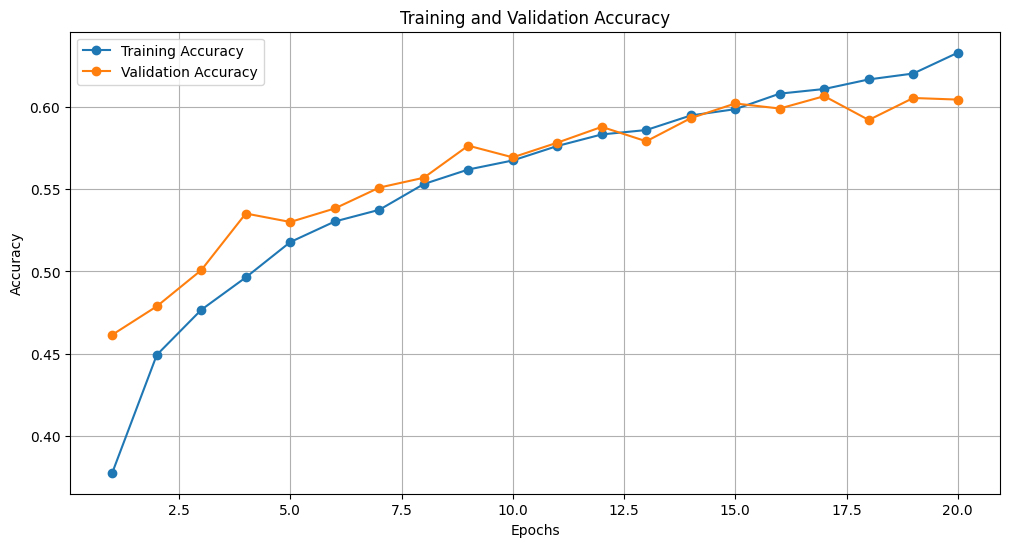

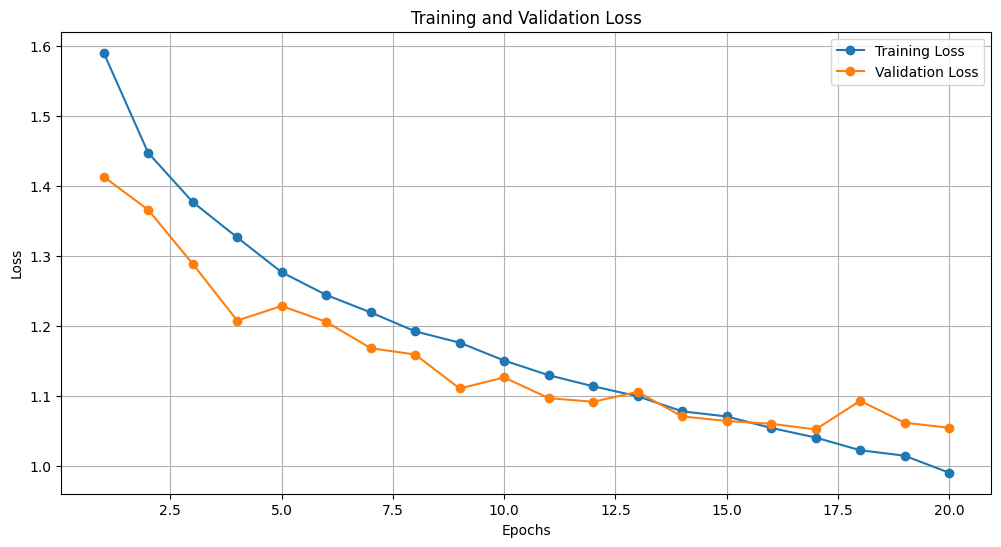

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_separate_training_and_validation(history, history_fine):
    #Step 1: Extract data for the initial training phase
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_initial = range(1, len(train_acc) + 1)

    #Step 2: Extract data for the fine-tuning phase
    fine_train_acc = history_fine.history['accuracy']
    fine_val_acc = history_fine.history['val_accuracy']
    fine_train_loss = history_fine.history['loss']
    fine_val_loss = history_fine.history['val_loss']
    epochs_fine = range(1, len(fine_train_acc) + 1)

    #Step 3: Plot accuracy for both phases
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_fine, fine_train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_fine, fine_val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('acc_plot1.png')
    plt.show()

    #Step 4: Plot loss for both phases
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_fine, fine_train_loss, label='Training Loss', marker='o')
    plt.plot(epochs_fine, fine_val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot model 1.png')
    plt.show()

# Calling the function after training our model
plot_separate_training_and_validation(history, history_fine)


# Testing on Real faces

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.5820 - loss: 1.1123
Test Loss: 1.0054, Test Accuracy: 0.6336
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step
Calculated Accuracy: 0.6336
Precision: 0.6346
Recall: 0.6336
F1 Score: 0.6278


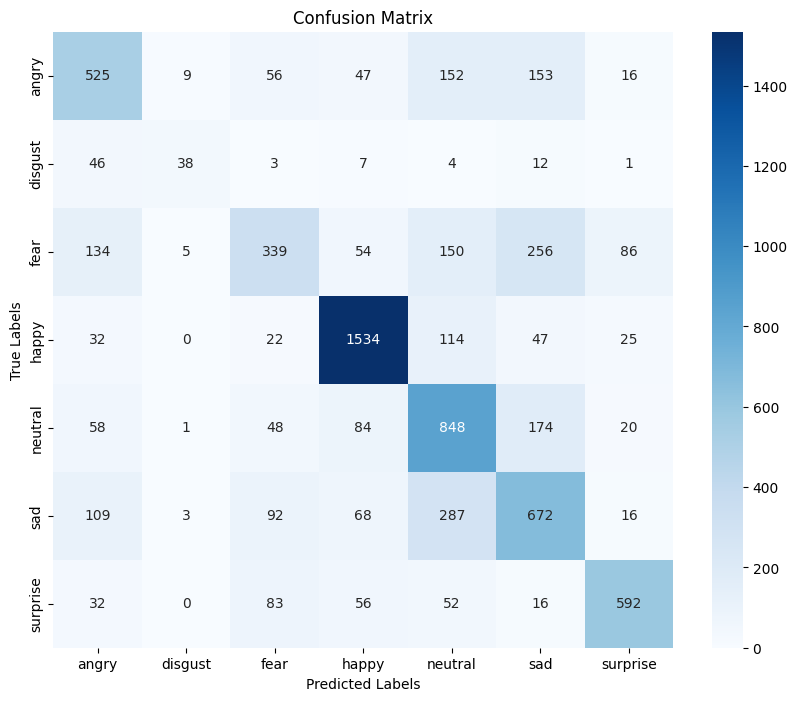

Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.55      0.55       958
     disgust       0.68      0.34      0.46       111
        fear       0.53      0.33      0.41      1024
       happy       0.83      0.86      0.85      1774
     neutral       0.53      0.69      0.60      1233
         sad       0.51      0.54      0.52      1247
    surprise       0.78      0.71      0.75       831

    accuracy                           0.63      7178
   macro avg       0.63      0.58      0.59      7178
weighted avg       0.63      0.63      0.63      7178



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the saved model
model = load_model('emotion_detection_vgg16_finetuned.h5')

# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]:.4f}, Test Accuracy: {eval_result[1]:.4f}")

# Predicting on the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_labels = test_generator.classes  # True labels from the test generator

# We Calculate Metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# And then we print Metrics
print(f"Calculated Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#Loading Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = list(test_generator.class_indices.keys())

#Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('CM1.png')
plt.show()

#Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [ ]:
unique, counts = np.unique(y_pred_labels, return_counts=True)
print("Predicted Class Distribution:", dict(zip(unique, counts)))

unique_true, counts_true = np.unique(y_true_labels, return_counts=True)
print("True Class Distribution:", dict(zip(unique_true, counts_true)))

Predicted Class Distribution: {0: 910, 1: 111, 2: 613, 3: 2046, 4: 1492, 5: 1269, 6: 737}
True Class Distribution: {0: 958, 1: 111, 2: 1024, 3: 1774, 4: 1233, 5: 1247, 6: 831}


# Testing on the Fake faces generated by AI
### Same steps to follow as we did for testing on real faces

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - accuracy: 0.2882 - loss: 2.1519
Test Loss: 2.1800, Test Accuracy: 0.2683
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Calculated Accuracy: 0.2683
Precision: 0.3192
Recall: 0.2683
F1 Score: 0.2085


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


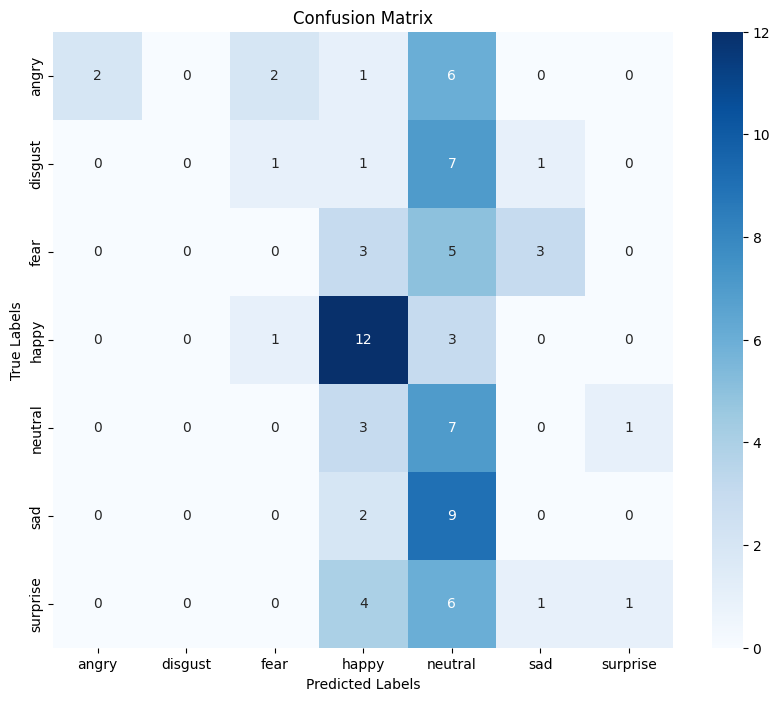

Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.18      0.31        11
     disgust       0.00      0.00      0.00        10
        fear       0.00      0.00      0.00        11
       happy       0.46      0.75      0.57        16
     neutral       0.16      0.64      0.26        11
         sad       0.00      0.00      0.00        11
    surprise       0.50      0.08      0.14        12

    accuracy                           0.27        82
   macro avg       0.30      0.24      0.18        82
weighted avg       0.32      0.27      0.21        82



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the saved model
model = load_model('emotion_detection_vgg16_finetuned.h5')

# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]:.4f}, Test Accuracy: {eval_result[1]:.4f}")

# Predicting on the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_labels = test_generator.classes  # True labels from the test generator

# We Calculate Metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# We print the Metrics
print(f"Calculated Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Loading Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = list(test_generator.class_indices.keys())

# Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('CM1.png')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [6]:
unique, counts = np.unique(y_pred_labels, return_counts=True)
print("Predicted Class Distribution:", dict(zip(unique, counts)))

unique_true, counts_true = np.unique(y_true_labels, return_counts=True)
print("True Class Distribution:", dict(zip(unique_true, counts_true)))

Predicted Class Distribution: {0: 2, 2: 4, 3: 26, 4: 43, 5: 5, 6: 2}
True Class Distribution: {0: 11, 1: 10, 2: 11, 3: 16, 4: 11, 5: 11, 6: 12}


<a href="https://colab.research.google.com/github/Lukog05/Deep-Learning-Project/blob/main/Updated_fer_2nd_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, Input
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

# Data Preparation

In [ ]:
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

# Paths for training and testing
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Normalization for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create Training and Testing generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True  # Enabling shuffling for training
)

#The test generator here is loading the real faces (not fake faces)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False  # Disabling shuffling for testing
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Loading the training and validation datasets
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 28709 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
# Input layer for grayscale images
input_layer = Input(shape=(48, 48, 1))

# Adding a Conv2D layer to convert the grayscale images to RGB
rgb_input = Conv2D(3, (3, 3), padding="same", activation=None)(input_layer)

# Load the VGG16 base model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# We Use the output of the RGB conversion as input to the base model
vgg_output = base_model(rgb_input)

# Freeze all layers except the last 4 layers in VGG16
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Adding custom layers
x = Dropout(0.5)(vgg_output)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(32, kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Output layer for 7 classes
output_layer = Dense(7, activation="softmax")(x)

# Build the final model and compile it
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,735,909 (56.21 MB)

 Trainable params: 7,099,429 (27.08 MB)

 Non-trainable params: 7,636,480 (29.13 MB)

In [ ]:
# Get the class distribution from train_generator
train_class_counts = Counter(train_generator.classes)
print("Training Class Distribution:", train_class_counts)

# Maximum count among the classes
max_count = max(train_class_counts.values())
print("Maximum Class Count:", max_count)

Training Class Distribution: Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Maximum Class Count: 7215


In [ ]:
model.build(input_shape=(None, 48, 48, 1))  # Replace with appropriate shape

In [ ]:
#Defining the method for calculating f1 scores
def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val


In [ ]:
#A metric list which has list of metrics we need
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
#Loading and compiling the Adam optimizer
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
from collections import Counter

# Get class distribution from train_generator
train_class_counts = Counter(train_generator.classes)
print("Training Class Distribution:", train_class_counts)

# Calculate class weights
max_count = max(train_class_counts.values())
class_weights = {i: max_count / count for i, count in train_class_counts.items()}
print("Class Weights:", class_weights)

# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=test_generator,
    class_weight=class_weights,
    epochs=20,
    callbacks=[lrd, mcp, es]
)

# Save the model
model.save('/kaggle/working/emotion_detection_vgg16_model 2.h5')

# Evaluate the model
results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")

Training Class Distribution: Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Class Weights: {0: 1.8060075093867334, 1: 16.548165137614678, 2: 1.7610446668293873, 3: 1.0, 4: 1.4531722054380665, 5: 1.4937888198757765, 6: 2.275307473982971}
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.1646 - auc: 0.5450 - f1_score: 0.0077 - loss: 3.4496 - precision: 0.2620 - recall: 0.0039 - val_accuracy: 0.1707 - val_auc: 0.5307 - val_f1_score: 0.0000e+00 - val_loss: 1.9415 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 69ms/step - accuracy: 0.1698 - auc: 0.5479 - f1_score: 0.0030 - loss: 3.4142 - precision: 0.1993 - recall: 0.0015 - val_accuracy: 0.1829 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 1.9662 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.1746 - auc: 0.5580

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2785 - auc: 0.5370 - f1_score: 0.0351 - loss: 2.0303 - precision: 0.3333 - recall: 0.0081            
Test Loss: 2.0185, Test Accuracy: 0.2927


# Testing on Real faces and visualizing it

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 0.0519 - auc: 0.5254 - f1_score: 0.0307 - loss: 1.8733 - precision: 0.0908 - recall: 0.0010   
Test Loss: 1.8339, Test Accuracy: 0.2260
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
Calculated Accuracy: 0.2260
Precision: 0.2316
Recall: 0.2260
F1 Score: 0.1379


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


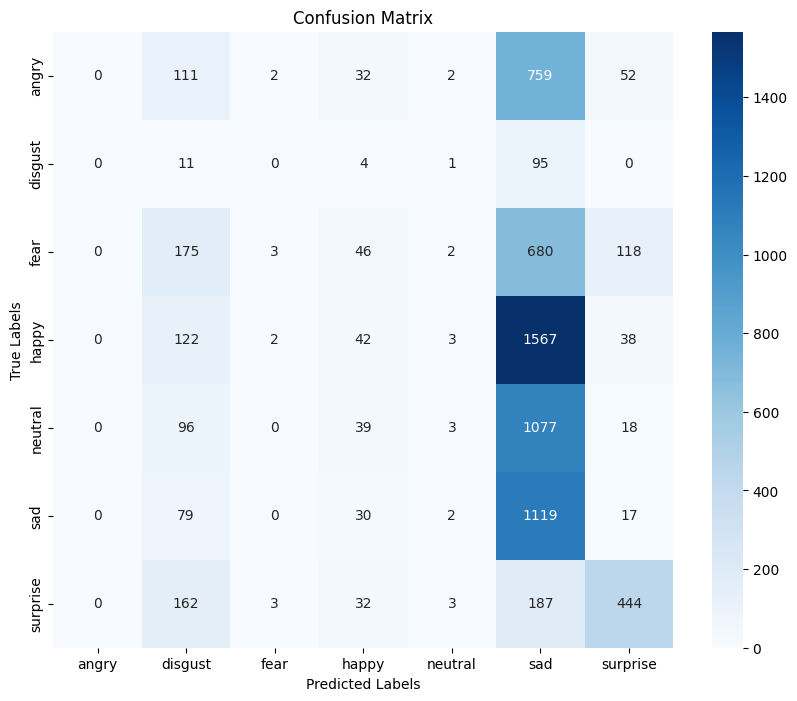

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.01      0.10      0.03       111
        fear       0.30      0.00      0.01      1024
       happy       0.19      0.02      0.04      1774
     neutral       0.19      0.00      0.00      1233
         sad       0.20      0.90      0.33      1247
    surprise       0.65      0.53      0.58       831

    accuracy                           0.23      7178
   macro avg       0.22      0.22      0.14      7178
weighted avg       0.23      0.23      0.14      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/kaggle/working/emotion_detection_vgg16_model 2.h5')

# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]:.4f}, Test Accuracy: {eval_result[1]:.4f}")

# Predict on the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_labels = test_generator.classes  # True labels from the test generator

# Calculate Metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print Metrics
print(f"Calculated Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = list(test_generator.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('CM1.png')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# Visualizing the training and validation outputs

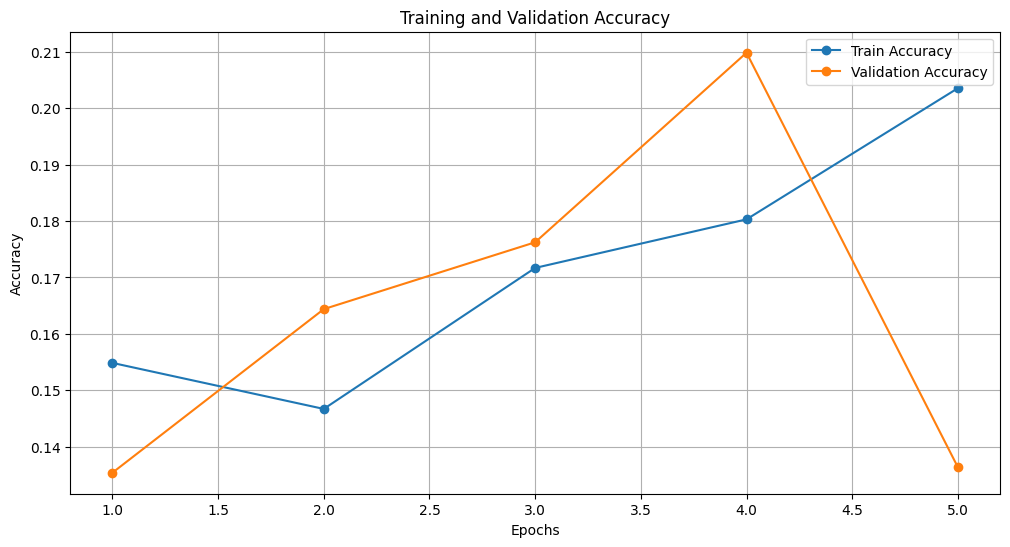

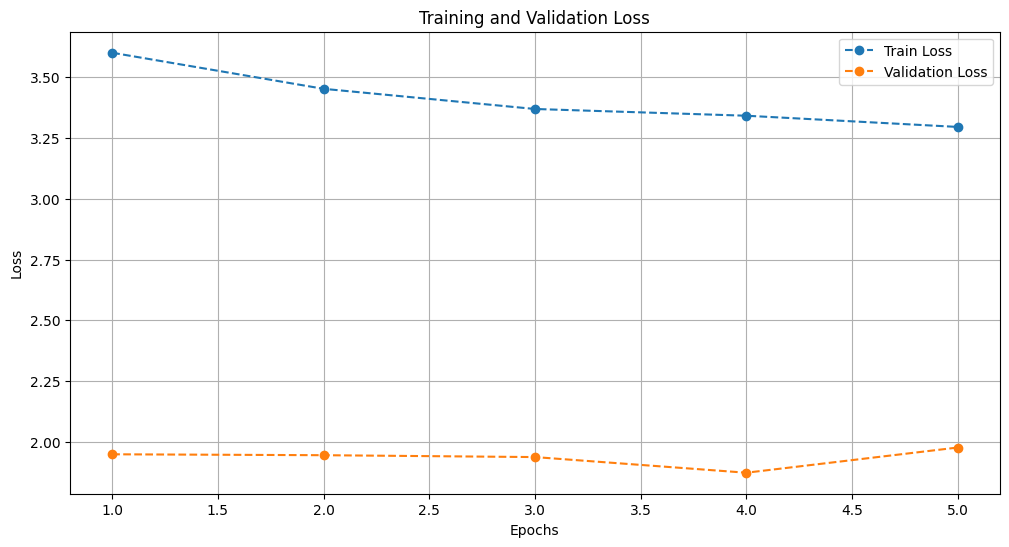

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss, and save as PNG
def plot_training_history_with_metrics(history):
    # Extract training and validation accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('train_val_accuracy_plot.png')
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='--')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('train_val_loss_plot.png')
    plt.show()

# Call the function to plot and save accuracy and loss plots
plot_training_history_with_metrics(history)


# Testing on Fake faces and visualizing it
### Same code to what we used for testing on real faces


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2785 - auc: 0.5370 - f1_score: 0.2378 - loss: 2.0303 - precision: 0.3333 - recall: 0.0081
Test Loss: 2.0185, Test Accuracy: 0.2927
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 839ms/step
Calculated Accuracy: 0.2927
Precision: 0.2811
Recall: 0.2927
F1 Score: 0.2765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


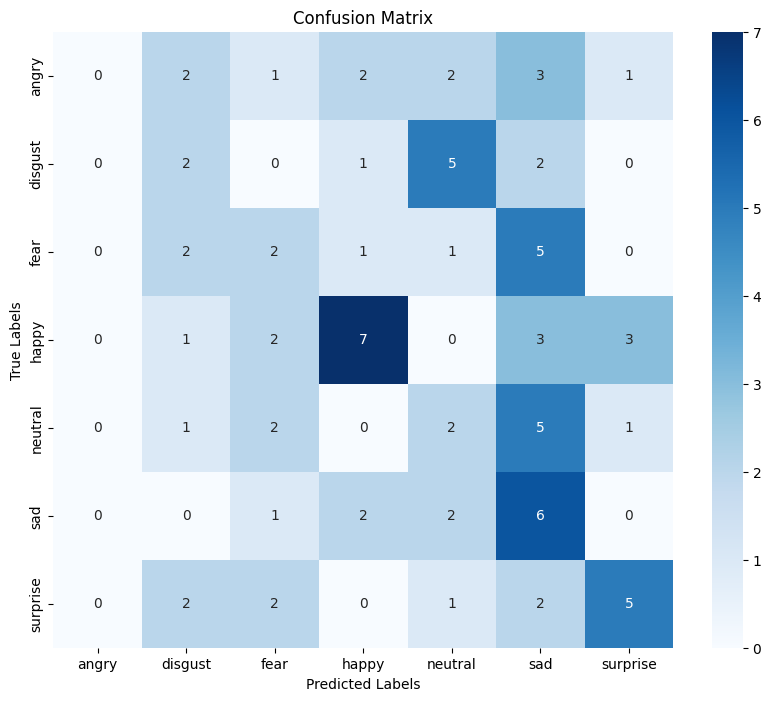

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        11
     disgust       0.20      0.20      0.20        10
        fear       0.20      0.18      0.19        11
       happy       0.54      0.44      0.48        16
     neutral       0.15      0.18      0.17        11
         sad       0.23      0.55      0.32        11
    surprise       0.50      0.42      0.45        12

    accuracy                           0.29        82
   macro avg       0.26      0.28      0.26        82
weighted avg       0.28      0.29      0.28        82



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/kaggle/working/emotion_detection_vgg16_model 2.h5')

# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]:.4f}, Test Accuracy: {eval_result[1]:.4f}")

# Predict on the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_labels = test_generator.classes  # True labels from the test generator

# Calculate Metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print Metrics
print(f"Calculated Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_names = list(test_generator.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('CM1.png')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))